# Test X3 & X4: Prediction with Full Covariance Matrix GPU

These test capture the runtime for the Cholesky decomposition with GPRat on the CPU.
We use a fixed problem size of $32768=2^{15}$, an increasing number of tiles in $\{1,2,4,8,16,32,64,128,256,512\}$, an increasing number of cores in $\{6,12,24,48\}$, 8 regressors and loop 10 times.
Note that we do not account for the time it takes to return the data to the callee.

Findings:

- There is no optimal number of cores. Therefore, we will use 48 cores for the other tests.
- ...

In [1]:
# setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import utils

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams.update({'font.size': 11})
mpl.rcParams.update({'errorbar.capsize': 5})
mpl.rcParams.update({'grid.linewidth': 0.5})

In [3]:
def mean_stddev(df, groupby_cols):
    new_df = df[df["i_loop"] != 0]
    new_df = (
        new_df.groupby(groupby_cols)["time"].agg(["mean", "std", "count"]).reset_index()
    )
    new_df.rename(columns={"std": "stddev", "count": "n_loops"}, inplace=True)
    return new_df

In [4]:
df_full = pd.read_csv("./data/X3/output-gpu.csv")
df_full = mean_stddev(df_full, ["n_cores", "n_train", "n_test", "n_tiles", "n_reg", "n_streams"])

In [6]:
# load data

apex_dir_steps = "./data/X4/"

names_steps = [
    "predict_full_cov_step ressource allocation",
    "predict_full_cov_step assembly",
    "predict_full_cov_step cholesky",
    "predict_full_cov_step forward",
    "predict_full_cov_step backward",
    "predict_full_cov_step forward KcK",
    "predict_full_cov_step prediction",
    "predict_full_cov_step full cov",
    "predict_full_cov_step pred uncer",
    "predict_full_cov_step copyback",
    "predict_full_cov_step ressource destroy",
    "assemble K_tiles",
    "assemble alpha_tiles",
    "assemble prior_K_tiles_full",
    "assemble cross_covariance_tiles",
    "assemble t_cross_covariance_tiles",
    "assemble zeros",
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
    "forward trsv",
    "forward gemv",
    "backward trsv",
    "backward gemv",
    "forward_KcK trsm",
    "forward_KcK gemm",
    "predict gemv",
    "full_cov gemm",
    "pred_uncer diag_tile",
]

file_headers = ["n_cores", "n_train", "n_test", "n_tiles", "n_reg", "n_streams", "n_loops"]

def apex_files_to_df(dir, names):
    data = []
    for filename in os.listdir(dir):
        if filename.endswith(".csv"):
            parts = filename.replace("apex_profiles_", "").replace(".csv", "").split("_")
            file_params = dict(zip(file_headers, map(int, parts)))
            file_path = os.path.join(dir, filename)
            df = pd.read_csv(file_path)
            df = df[df['name'].isin(names)]
            for key, value in file_params.items():
                df[key] = value
            data.append(df)
    df_combined = pd.concat(data, ignore_index=True)
    df_combined = df_combined.sort_values(by='n_tiles')
    return df_combined

df_steps = apex_files_to_df(apex_dir_steps, names_steps)

    n_cores  n_train  n_test  n_tiles  n_reg  n_streams      mean    stddev  \
18       48    16384   16384        4      8          4  2.220876  0.002552   
17       48    16384   16384        4      8          2  2.225208  0.001422   
19       48    16384   16384        4      8          8  2.225233  0.003302   
8        48    16384   16384        2      8          1  2.226651  0.004438   
20       48    16384   16384        4      8         16  2.231595  0.004989   
9        48    16384   16384        2      8          2  2.234164  0.006074   
34       48    16384   16384       16      8          8  2.234298  0.005305   
11       48    16384   16384        2      8          8  2.236755  0.004564   
16       48    16384   16384        4      8          1  2.237231  0.002143   
35       48    16384   16384       16      8         16  2.238421  0.006457   

    n_loops  
18       10  
17       10  
19       10  
8        10  
20       10  
9        10  
34       10  
11       10  
16  

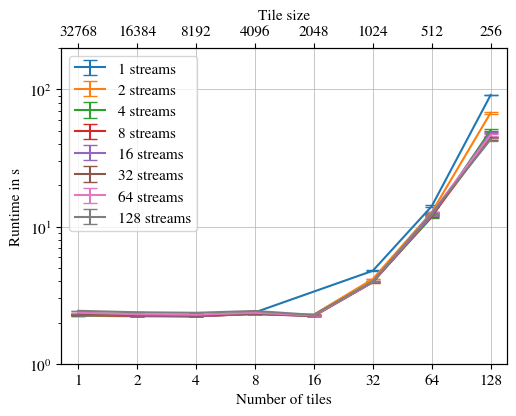

In [ ]:
# plot for predict full cov

n_train = 32768

fig, ax = plt.subplots(figsize=(5, 4))
ax_top = ax.twiny()

xticks = df_full["n_tiles"].unique()
tile_sizes = n_train / xticks
ax.set_xlabel("Number of tiles")
ax.set_ylabel("Runtime in s")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(which="both")
ax.grid(False, which="minor")
ax.set_xlim(0.82, 155)
ax.set_ylim(1, 200)

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

for n_streams, group in df_full.groupby("n_streams"):
    err = utils.confidence_error(group, 0.95)
    plt.errorbar(group['n_tiles'], group['mean'], yerr=err, label=f"{n_streams} streams")

plt.legend()
plt.tight_layout(pad=0.1)
plt.savefig("./pdf/predict-fullcov-gpu.pdf")

/tmp/ipykernel_27735/3305781452.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name["mean"] = df_name["mean"].values
/tmp/ipykernel_27735/3305781452.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name["mean"] = df_name["mean"].values
/tmp/ipykernel_27735/3305781452.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

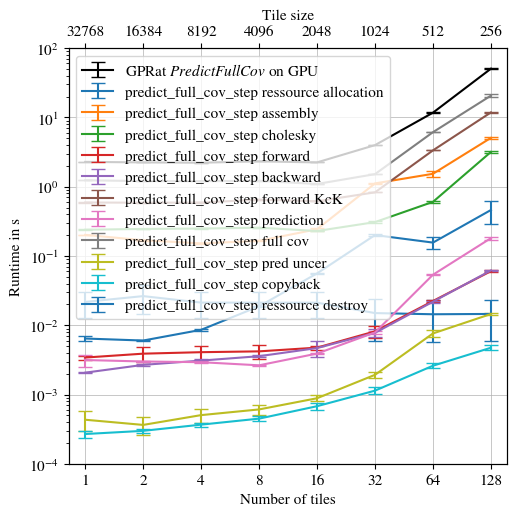

In [20]:
# plot for predict fullcov steps

n_train = 32768
n_cores = 48

fig, ax = plt.subplots(figsize=(5, 5))

ax.set_xlabel("Number of tiles")
ax.set_ylabel("Runtime in s")
ax.set_xlim(0.82, 155)
ax.set_ylim(10**(-4), 10**2)

xticks = df_steps["n_tiles"].unique()
tile_sizes = n_train / xticks

ax_top = ax.twiny()

xticks = df_full["n_tiles"].unique()
tile_sizes = n_train / xticks

ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(which="both")
ax.grid(False, which="minor")

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

df_full_4 = df_full[df_full["n_streams"] == 4]
err = utils.confidence_error(df_full_4, 0.95)
ax.errorbar(
    df_full_4["n_tiles"],
    df_full_4["mean"],
    yerr=err,
    color="black",
    label=r"GPRat $\mathit{Predict FullCov}$ on GPU",
)

names = [
    "predict_full_cov_step ressource allocation",
    "predict_full_cov_step assembly",
    "predict_full_cov_step cholesky",
    "predict_full_cov_step forward",
    "predict_full_cov_step backward",
    "predict_full_cov_step forward KcK",
    "predict_full_cov_step prediction",
    "predict_full_cov_step full cov",
    "predict_full_cov_step pred uncer",
    "predict_full_cov_step copyback",
    "predict_full_cov_step ressource destroy",
]

# colors = [
#     "tab:blue",
#     "tab:orange",
# ]
# legend = [
#     r"Step 1: Assemble $\mathbf{K}$-tiles",
#     f"Step 2: Tiled Cholesky Decomposition",
# ]

for name in names:
    df_name = df_steps[(df_steps["name"] == name) & (df_steps["n_streams"] == 4)]
    df_name["mean"] = df_name["mean"].values
    conf = 0.95
    if name == "predict_full_cov_step ressource allocation":
        conf = 0.5
    err = utils.confidence_error(df_name, conf)
    ax.errorbar(
        df_name["n_tiles"],
        df_name["mean"] / 10**9,
        yerr=err / 10**9,
        # color=color,
        label=name
    )

ax.legend()
fig.tight_layout(pad=0.1)
fig.savefig("./pdf/predict-fullcov-cpu-steps.pdf")

/home/moellh/dev/GPRat.git/plot/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_60559/2388980630.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name["acc_stddev"] = np.sqrt(df_name["stddev"]**2 * df_name["num samples/calls"] / df_name["n_loops"])


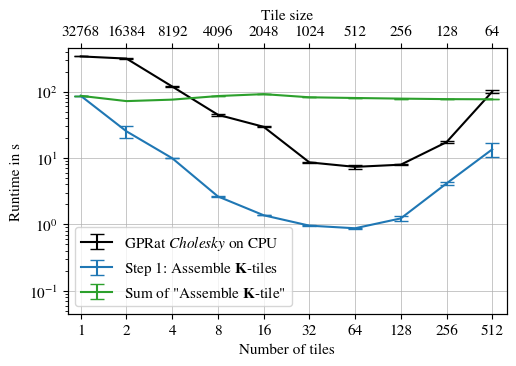

In [ ]:
# plot for cholesky: Assembly

n_train = 32768
n_cores = 48

fig, ax = plt.subplots(figsize=(5, 3.5))
ax_top = ax.twiny()

xticks = df_cholesky["n_tiles"].unique()
tile_sizes = n_train / xticks
ax.set_xlim(0.82, 640)
ax.set_ylim(0.045, 4.5*10**2)
ax.set_xlabel("Number of tiles")
ax.set_ylabel("Runtime in s")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(True, which="both")
ax.grid(False, which="minor")

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

df_full_48 = df_cholesky[df_cholesky["n_cores"] == n_cores]
err = utils.confidence_error(df_full_48, 0.95)
plt.errorbar(
    df_full_48["n_tiles"],
    df_full_48["mean"] / 10**9,
    yerr=err / 10**9,
    color="black",
    label=r"GPRat $\it{Cholesky}$ on CPU",
)

df_step_assembly = df_steps[df_steps["name"] == "cholesky_step assembly"]
err = utils.confidence_error(df_step_assembly, 0.95)
plt.errorbar(
    df_step_assembly["n_tiles"],
    df_step_assembly["mean"] / 10**9,
    yerr=err / 10**9,
    label=r"Step 1: Assemble $\mathbf{K}$-tiles",
)


names_blas = [
    "assemble K_tiles",
]
names_steps_legend = [
    "Assemble tiles",
]

for i, (name, legend_name) in enumerate(zip(names_blas, names_steps_legend)):
    df_name = df_steps[df_steps["name"] == name]
    df_name["acc_stddev"] = np.sqrt(df_name["stddev"]**2 * df_name["num samples/calls"] / df_name["n_loops"])
    err = utils.confidence_error(df_name, 0.95, "acc_stddev")
    plt.errorbar(
        df_name["n_tiles"],
        df_name["mean"] / 10**9 * df_name["num samples/calls"] / 10,
        yerr=err / 10**9,
        label=r'Sum of "Assemble $\mathbf{K}$-tile"',
        color="tab:green",
    )

plt.legend()
plt.tight_layout(pad=0.1)
plt.savefig("./pdf/cholesky-cpu-assembly.pdf")

/home/moellh/dev/GPRat.git/plot/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_60559/3652241221.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name["acc_stddev"] = np.sqrt(df_name["stddev"]**2 * df_name["num samples/calls"] / df_name["n_loops"])
/home/moellh/dev/GPRat.git/plot/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_60559/3652241221.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

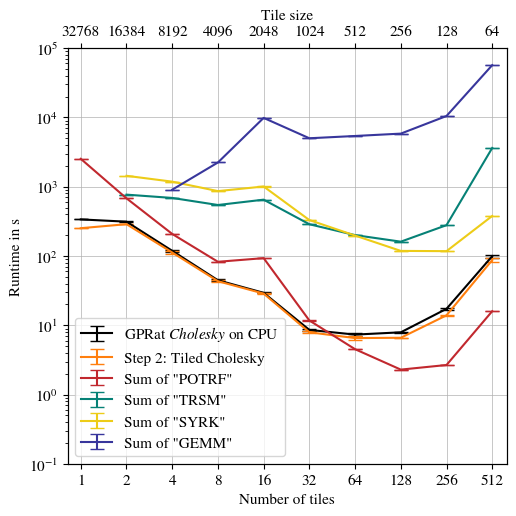

In [ ]:
# plot for cholesky BLAS

n_train = 32768
n_cores = 48

fig, ax = plt.subplots(figsize=(5, 5))
ax_top = ax.twiny()

xticks = df_cholesky["n_tiles"].unique()
tile_sizes = n_train / xticks
ax.set_xlim(0.82, 640)
ax.set_ylim(0.1, 10**5)
ax.set_xlabel("Number of tiles")
ax.set_ylabel("Runtime in s")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(True, which="both")
ax.grid(False, which="minor")

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

df_full_48 = df_cholesky[df_cholesky["n_cores"] == n_cores]
err = utils.confidence_error(df_full_48, 0.95)
plt.errorbar(
    df_full_48["n_tiles"],
    df_full_48["mean"] / 10**9,
    yerr=err / 10**9,
    color="black",
    label=r"GPRat $\it{Cholesky}$ on CPU",
)

name = "cholesky_step cholesky"
label = "Step 2: Tiled Cholesky"
err = utils.confidence_error(df_steps[df_steps["name"] == name], 0.95)
plt.errorbar(
    df_steps[df_steps["name"] == name]["n_tiles"],
    df_steps[df_steps["name"] == name]["mean"] / 10**9,
    yerr=err / 10**9,
    label=f"{label}",
    color="tab:orange",
    )

names_blas = [
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
]
names_steps_legend = [
    'Sum of "POTRF"',
    'Sum of "TRSM"',
    'Sum of "SYRK"',
    'Sum of "GEMM"',
]
colors = [
    "#c1282e",
    "#068176",
    "#edcc18",
    "#38369c",
]

for name, legend_name, color in zip(names_blas, names_steps_legend, colors):
    df_name = df_steps[df_steps["name"] == name]
    df_name["acc_stddev"] = np.sqrt(df_name["stddev"]**2 * df_name["num samples/calls"] / df_name["n_loops"])
    err = utils.confidence_error(df_name, 0.95)
    plt.errorbar(
        df_steps[df_steps["name"] == name]["n_tiles"],
        df_steps[df_steps["name"] == name]["mean"]
        / 10**9
        * df_steps[df_steps["name"] == name]["num samples/calls"],
        yerr=err / 10**9,
        label=f"{legend_name}",
        color=color,
    )

plt.legend(loc="lower left")
plt.tight_layout(pad=0.1)
plt.savefig("./pdf/cholesky-cpu-blas.pdf")